<a href="https://colab.research.google.com/github/bugeki/portfolio_projects_of_data_analysis/blob/main/forecasting_bus_demand_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Forecasting bus demand in Banana Republic municipalities.***

The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. The dataset format is as follows (comma separated values): MUNICIPALITY_ID, TIMESTAMP, USAGE, TOTAL_CAPACITY where municipality_id is an anonymization to disguise the actual names, timestamp represents the exact time of the measurement, usage is the number of buses in use at the time of measurement and total_capacity represents the total number of buses in the municipality. There are 10 municipalities (ids from 0 to 9), and two measurements for an hour. The committee asks you to forecast the hourly bus usages for next week for each municipality. Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour, and you should model this data with a time series model of your selection. (It would be a nice idea to implement a very simple baseline model first, and then try to improve the accuracy by introducing more complex methods eventually. The bare minimum requirement of the task is one simple baseline and one complex method.) The committee says that they will use the last two weeks (starting from 2017-08-05 to 2017-08-19) as assessment (test) data, hence your code should report the error (in the criterion you chose for the task) for the last two weeks. You may use true values for the prediction of the last week of test data, then combine the error of the first and last week of the test separately. Keep in mind that the dataset has missing data, hence a suitable missing data interpolation would be useful.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [ ]:
!pip install colorama
import colorama
from colorama import Fore, Style  # makes strings colored
!pip3 install termcolor
from termcolor import colored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Recognizing and Understanding Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/RNN/municipality_bus_utilization.csv')

In [ ]:
df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [ ]:
def missing(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

def missing_values(df):
    return missing(df)[missing(df)['Missing_Number']>0]
    
def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n',
          f"There is ", df.shape[0], " observation and ", df.shape[1], " columns in the dataset.", '\n',
          colored('-'*79, 'magenta', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'magenta', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'magenta', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'magenta', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'magenta', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'magenta', attrs=['bold']), sep='')

def first_looking_col(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False)) 

In [ ]:
first_looking(df)

Shape:(13070, 4)
There is 13070 observation and 4 columns in the dataset.
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB
None
-------------------------------------------------------------------------------
Number of Uniques:
timestamp          1309
municipality_id      10
usage              2346
total_capacity       10
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------

In [ ]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [ ]:
first_looking_col("usage")

column name    :  usage
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2346
411     69
354     62
399     31
410     28
623     27
        ..
2830     1
2783     1
2664     1
2463     1
1680     1
Name: usage, Length: 2346, dtype: int64


In [ ]:
df.duplicated().value_counts()

False    13070
dtype: int64

In [ ]:
# convert the timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Hourly max value

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 408.6 KB


In [ ]:
#dfm = df.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
dfm = df.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()

In [ ]:
dfm

timestamp
2017-06-04 07:00:00   1090.000
2017-06-04 08:00:00   2016.000
2017-06-04 09:00:00   2811.000
2017-06-04 10:00:00   3178.000
2017-06-04 11:00:00   3257.000
                        ...   
2017-08-19 12:00:00   3157.000
2017-08-19 13:00:00   3194.000
2017-08-19 14:00:00   3183.000
2017-08-19 15:00:00   3111.000
2017-08-19 16:00:00   2779.000
Freq: H, Name: usage, Length: 1834, dtype: float64

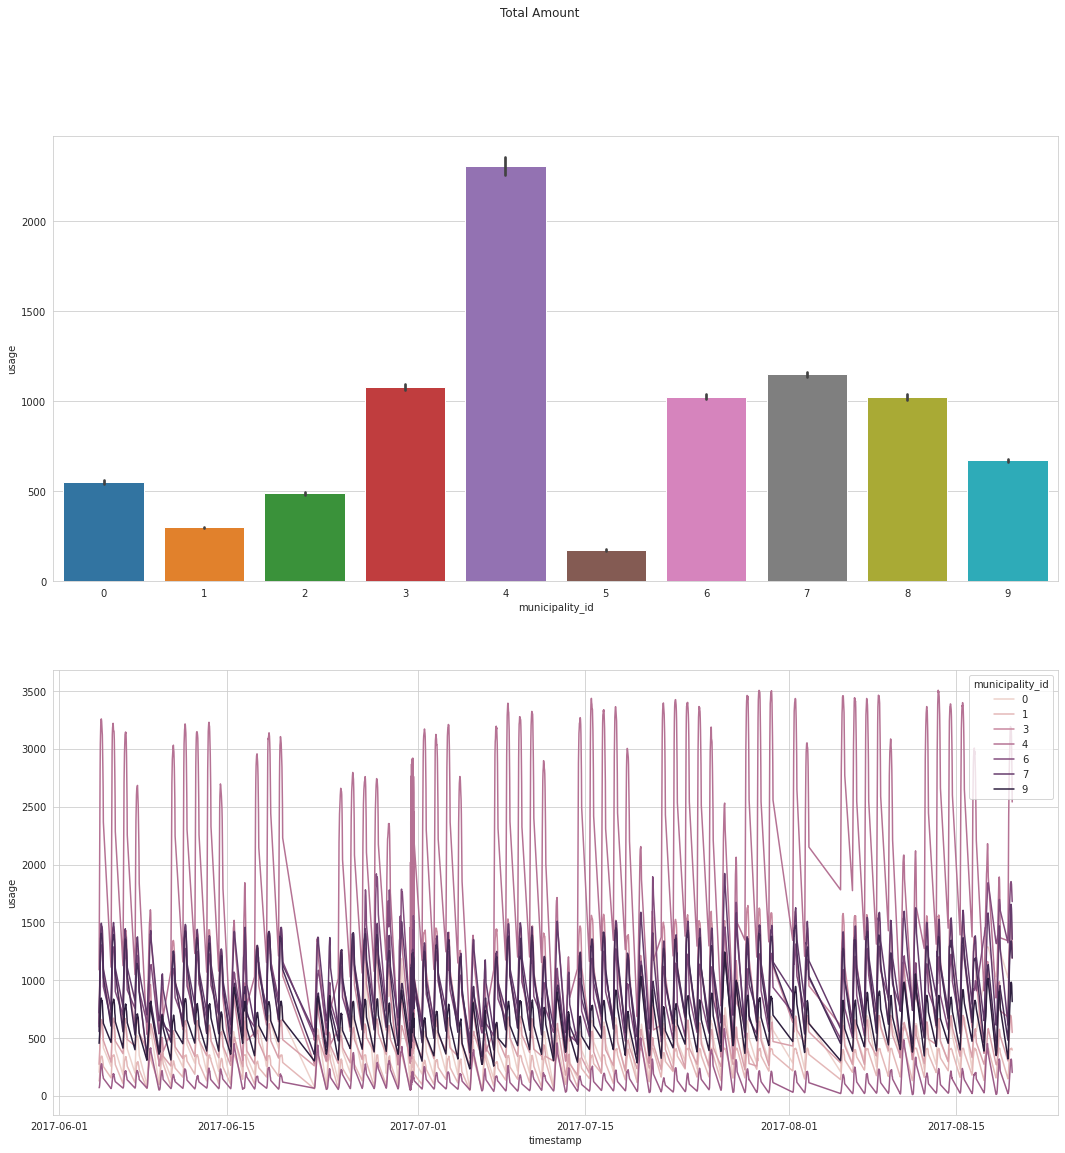

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(18,18))
s = sns.barplot(ax = ax1, x="municipality_id", y="usage", data=df)
s = sns.lineplot(ax = ax2, x='timestamp', y="usage", data=df, color="red", hue='municipality_id')
plt.suptitle("Total Amount")
plt.show();

In [ ]:
df.tail()

,timestamp,municipality_id,usage,total_capacity
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113
13069,2017-08-19 16:30:35,3,1189,1930


### Separating municipalities

In [ ]:
muni_id=list(df['municipality_id'].unique())

In [ ]:
muni_id.sort()

In [ ]:
muni_id

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
d = {i: df[df['municipality_id'] == i] for i in muni_id}

In [ ]:
%%script echo skipping
df1=d[1]
df2=d[2]
df3=d[3]
df4=d[4]
df5=d[5]
df6=d[6]
df7=d[7]
df8=d[8]
df9=d[9]


skipping


###df0

In [ ]:
df0=d[0]

In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 3 to 13062
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        1307 non-null   datetime64[ns]
 1   municipality_id  1307 non-null   int64         
 2   usage            1307 non-null   int64         
 3   total_capacity   1307 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 51.1 KB


In [ ]:
df0m = df0.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()


In [ ]:
df0m.head(30)

timestamp
2017-06-04 07:00:00   204.000
2017-06-04 08:00:00   332.000
2017-06-04 09:00:00   485.000
2017-06-04 10:00:00   583.000
2017-06-04 11:00:00   614.000
2017-06-04 12:00:00   613.000
2017-06-04 13:00:00   605.000
2017-06-04 14:00:00   585.000
2017-06-04 15:00:00   520.000
2017-06-04 16:00:00   470.000
2017-06-04 17:00:00       NaN
2017-06-04 18:00:00       NaN
2017-06-04 19:00:00       NaN
2017-06-04 20:00:00       NaN
2017-06-04 21:00:00       NaN
2017-06-04 22:00:00       NaN
2017-06-04 23:00:00       NaN
2017-06-05 00:00:00       NaN
2017-06-05 01:00:00       NaN
2017-06-05 02:00:00       NaN
2017-06-05 03:00:00       NaN
2017-06-05 04:00:00       NaN
2017-06-05 05:00:00       NaN
2017-06-05 06:00:00       NaN
2017-06-05 07:00:00   255.000
2017-06-05 08:00:00   335.000
2017-06-05 09:00:00   487.000
2017-06-05 10:00:00   595.000
2017-06-05 11:00:00   612.000
2017-06-05 12:00:00   595.000
Freq: H, Name: usage, dtype: float64

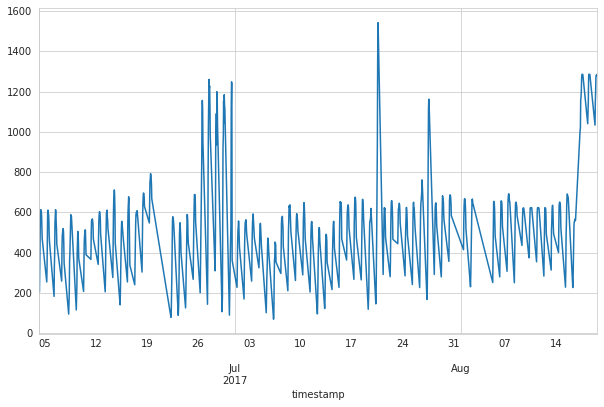

In [ ]:
df0m.interpolate().plot()

In [ ]:
df0=df0m.interpolate() 

In [ ]:
df0.columns='usage' 

In [ ]:
df0=pd.DataFrame(df0) 

In [ ]:
df0

,usage
timestamp,
2017-06-04 07:00:00,204.000
2017-06-04 08:00:00,332.000
2017-06-04 09:00:00,485.000
2017-06-04 10:00:00,583.000
2017-06-04 11:00:00,614.000
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


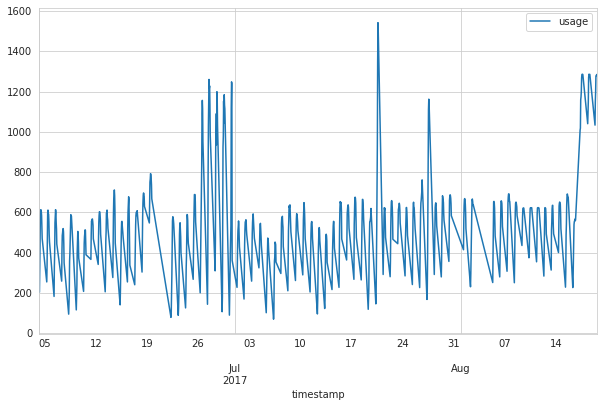

In [ ]:
df0.plot()

# Preprocessing of Data

## Train Test Split

In [ ]:
df0.loc['2017-08-05 00:00:00':] 

,usage
timestamp,
2017-08-05 00:00:00,300.250
2017-08-05 01:00:00,294.219
2017-08-05 02:00:00,288.188
2017-08-05 03:00:00,282.156
2017-08-05 04:00:00,276.125
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


In [ ]:
df0.shape

(1834, 1)

In [ ]:
df0.loc['2017-08-05 00:00:00':]   # 2 weeks test data

,usage
timestamp,
2017-08-05 00:00:00,0.156
2017-08-05 01:00:00,0.152
2017-08-05 02:00:00,0.148
2017-08-05 03:00:00,0.144
2017-08-05 04:00:00,0.140
...,...
2017-08-19 12:00:00,0.822
2017-08-19 13:00:00,0.823
2017-08-19 14:00:00,0.825


In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1834 entries, 2017-06-04 07:00:00 to 2017-08-19 16:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   usage   1834 non-null   float64
dtypes: float64(1)
memory usage: 93.2 KB


In [ ]:
train, test = df0.loc[:'2017-08-04 23:00:00'], df0.loc['2017-08-05 00:00:00':]
print(len(train), len(test))

1481 353


In [ ]:
train

,usage
timestamp,
2017-06-04 07:00:00,0.091
2017-06-04 08:00:00,0.178
2017-06-04 09:00:00,0.282
2017-06-04 10:00:00,0.348
2017-06-04 11:00:00,0.369
...,...
2017-08-04 19:00:00,0.177
2017-08-04 20:00:00,0.173
2017-08-04 21:00:00,0.169


In [ ]:
test

,usage
timestamp,
2017-08-05 00:00:00,0.156
2017-08-05 01:00:00,0.152
2017-08-05 02:00:00,0.148
2017-08-05 03:00:00,0.144
2017-08-05 04:00:00,0.140
...,...
2017-08-19 12:00:00,0.822
2017-08-19 13:00:00,0.823
2017-08-19 14:00:00,0.825


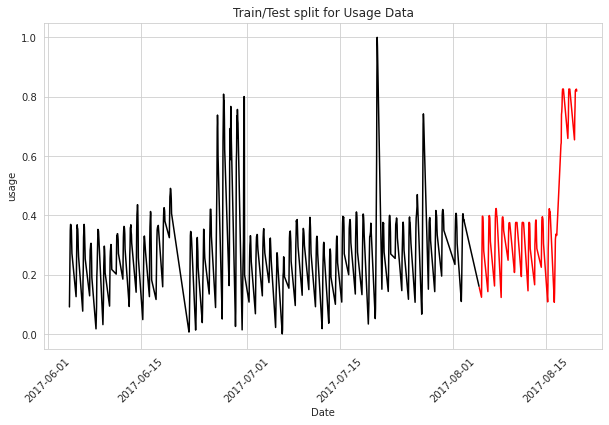

In [ ]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('usage')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Usage Data")
plt.show()

## Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# help(TimeseriesGenerator)

In [ ]:
length = 24             ### seasonity 
batch_size = 50         
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [ ]:
len(generator)

30

In [ ]:
generator[0]

(array([[[0.09097081],
         [0.1778683 ],
         [0.28173795],
         ...,
         [0.15478615],
         [0.14505544],
         [0.13532473]],
 
        [[0.1778683 ],
         [0.28173795],
         [0.34826884],
         ...,
         [0.14505544],
         [0.13532473],
         [0.12559403]],
 
        [[0.28173795],
         [0.34826884],
         [0.36931432],
         ...,
         [0.13532473],
         [0.12559403],
         [0.17990496]],
 
        ...,
 
        [[0.08897941],
         [0.07671419],
         [0.17854718],
         ...,
         [0.16734555],
         [0.15953836],
         [0.15173116]],
 
        [[0.07671419],
         [0.17854718],
         [0.22267481],
         ...,
         [0.15953836],
         [0.15173116],
         [0.14392396]],
 
        [[0.17854718],
         [0.22267481],
         [0.32518669],
         ...,
         [0.15173116],
         [0.14392396],
         [0.13611677]]]), array([[0.12559403],
        [0.17990496],
        [0.2

In [ ]:
X, y = generator[0]

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.09097081 0.1778683  0.28173795 ... 0.15173116 0.14392396 0.13611677]
Predict this y: 
 [[0.12559403]
 [0.17990496]
 [0.28309572]
 [0.35641548]
 [0.36795655]
 [0.35641548]
 [0.35437882]
 [0.3299389 ]
 [0.28581127]
 [0.26069246]
 [0.24842725]
 [0.23616203]
 [0.22389681]
 [0.21163159]
 [0.19936637]
 [0.18710115]
 [0.17483594]
 [0.16257072]
 [0.1503055 ]
 [0.13804028]
 [0.12577506]
 [0.11350984]
 [0.10124463]
 [0.08897941]
 [0.07671419]
 [0.17854718]
 [0.22267481]
 [0.32518669]
 [0.34487441]
 [0.36931432]
 [0.3604888 ]
 [0.32586558]
 [0.30414121]
 [0.25322471]
 [0.24541752]
 [0.23761032]
 [0.22980312]
 [0.22199593]
 [0.21418873]
 [0.20638153]
 [0.19857434]
 [0.19076714]
 [0.18295995]
 [0.17515275]
 [0.16734555]
 [0.15953836]
 [0.15173116]
 [0.14392396]
 [0.13611677]
 [0.12830957]]


# Modelling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
train_scaled.shape

(1481, 1)

In [ ]:
n_features = train_scaled.shape[1]

In [ ]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24, 100)           40800     
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping and Validation Generator

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5,restore_best_weights = True)

In [ ]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [ ]:
len(validation_generator)

7

In [ ]:
model.fit(x = generator,
          epochs = 120,
          validation_data = validation_generator,
          callbacks = [early_stop])

Epoch 1/120
30/30 [==============================] - 9s 84ms/step - loss: 0.0248 - val_loss: 0.0140
Epoch 2/120
30/30 [==============================] - 1s 45ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 3/120
30/30 [==============================] - 1s 48ms/step - loss: 0.0117 - val_loss: 0.0185
Epoch 4/120
30/30 [==============================] - 2s 50ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 5/120
30/30 [==============================] - 1s 49ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 6/120
30/30 [==============================] - 2s 50ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 7/120
30/30 [==============================] - 1s 48ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 8/120
30/30 [==============================] - 1s 49ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 9/120
30/30 [==============================] - 2s 50ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 10/120
30/30 [==============================] - 2s 51ms/step - loss: 0.0046 - val_loss: 0.0092

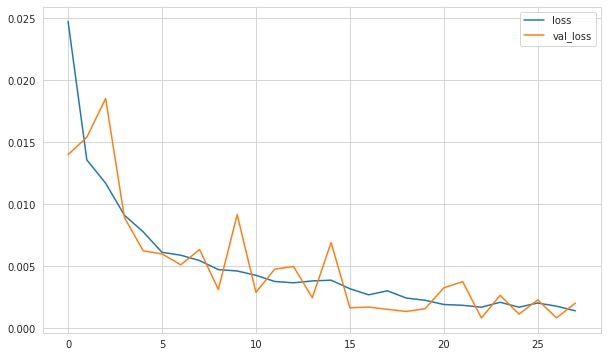

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# Evaluation on Test Data

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [ ]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [ ]:
predictions_scaled

[array([0.18807687], dtype=float32),
 array([0.20387863], dtype=float32),
 array([0.22235832], dtype=float32),
 array([0.24023116], dtype=float32),
 array([0.2557006], dtype=float32),
 array([0.26768196], dtype=float32),
 array([0.27574447], dtype=float32),
 array([0.2800404], dtype=float32),
 array([0.28113765], dtype=float32),
 array([0.27980664], dtype=float32),
 array([0.27683347], dtype=float32),
 array([0.272902], dtype=float32),
 array([0.26855004], dtype=float32),
 array([0.2641782], dtype=float32),
 array([0.2600853], dtype=float32),
 array([0.25650916], dtype=float32),
 array([0.25366005], dtype=float32),
 array([0.25174317], dtype=float32),
 array([0.25096664], dtype=float32),
 array([0.25153732], dtype=float32),
 array([0.25364542], dtype=float32),
 array([0.2574399], dtype=float32),
 array([0.26299992], dtype=float32),
 array([0.27030474], dtype=float32)]

In [ ]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.012977525125927647 
mae: 0.07485754994972399 
mse: 0.0081539808139819 
rmse: 0.09029939542423249


## Inverse Transformation and Comparing

In [ ]:
predictions = scaler.inverse_transform(predictions_scaled)

In [ ]:
compare = test[:24]

In [ ]:
compare['Predictions'] = predictions

In [ ]:
compare

,usage,Predictions
timestamp,,
2017-08-05 00:00:00,0.156,0.188
2017-08-05 01:00:00,0.152,0.204
2017-08-05 02:00:00,0.148,0.222
2017-08-05 03:00:00,0.144,0.240
2017-08-05 04:00:00,0.140,0.256
2017-08-05 05:00:00,0.136,0.268
2017-08-05 06:00:00,0.132,0.276
2017-08-05 07:00:00,0.128,0.280
2017-08-05 08:00:00,0.124,0.281


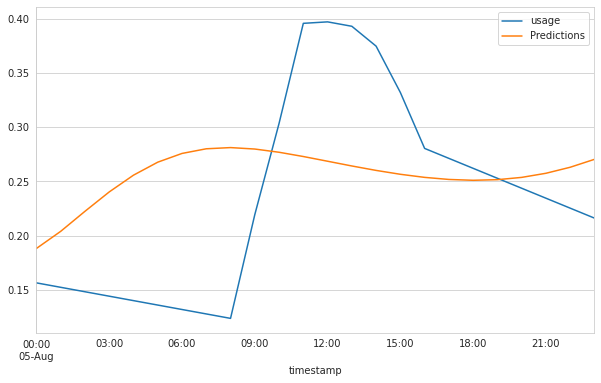

In [ ]:
compare.plot()

In [ ]:
eval_metrics(compare.usage, compare.Predictions)

r2_score: 0.012977525125927647 
mae: 0.07485754994972399 
mse: 0.0081539808139819 
rmse: 0.09029939542423249


# Retrain and Forecasting

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df0)

In [ ]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = 150, batch_size = batch_size)

In [ ]:
len(df0)

1834

In [ ]:
len(generator)

34

In [ ]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (150, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit(x = generator, epochs=60)

Epoch 1/60
34/34 [==============================] - 13s 239ms/step - loss: 0.0213
Epoch 2/60
34/34 [==============================] - 8s 237ms/step - loss: 0.0139
Epoch 3/60
34/34 [==============================] - 8s 237ms/step - loss: 0.0121
Epoch 4/60
34/34 [==============================] - 8s 241ms/step - loss: 0.0108
Epoch 5/60
34/34 [==============================] - 8s 240ms/step - loss: 0.0089
Epoch 6/60
34/34 [==============================] - 8s 238ms/step - loss: 0.0063
Epoch 7/60
34/34 [==============================] - 8s 238ms/step - loss: 0.0062
Epoch 8/60
34/34 [==============================] - 8s 241ms/step - loss: 0.0050
Epoch 9/60
34/34 [==============================] - 8s 240ms/step - loss: 0.0054
Epoch 10/60
34/34 [==============================] - 8s 241ms/step - loss: 0.0044
Epoch 11/60
34/34 [==============================] - 8s 240ms/step - loss: 0.0042
Epoch 12/60
34/34 [==============================] - 8s 238ms/step - loss: 0.0035
Epoch 13/60
34/34 [=====

In [ ]:
scaled_full_data.shape

(1834, 1)

In [ ]:
scaled_full_data[-150:].shape

(150, 1)

In [ ]:
forecast = []

first_eval_batch = scaled_full_data[-150:]
current_batch = first_eval_batch.reshape((1, 150, n_features))

for i in range(150):
    
    
    current_pred = model.predict(current_batch)
    
    
    forecast.append(current_pred[0]) 
    
    
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast

array([[0.79876417],
       [0.77605027],
       [0.75241625],
       [0.728966  ],
       [0.70617133],
       [0.6844418 ],
       [0.66418535],
       [0.64578581],
       [0.62954283],
       [0.61559999],
       [0.60389197],
       [0.59413999],
       [0.58595908],
       [0.57915711],
       [0.57419837],
       [0.5723772 ],
       [0.57476771],
       [0.57984269],
       [0.58250803],
       [0.57732445],
       [0.56258935],
       [0.54064512],
       [0.51552451],
       [0.49060908],
       [0.46765423],
       [0.44714069],
       [0.42897782],
       [0.41293263],
       [0.39878932],
       [0.38636833],
       [0.37548995],
       [0.36591116],
       [0.35726422],
       [0.34902033],
       [0.34053952],
       [0.33131155],
       [0.32151154],
       [0.31282073],
       [0.30882239],
       [0.31339955],
       [0.32660782],
       [0.34222195],
       [0.35215378],
       [0.35273957],
       [0.3446742 ],
       [0.3300994 ],
       [0.31187183],
       [0.293

In [ ]:
df0

,usage
timestamp,
2017-06-04 07:00:00,0.091
2017-06-04 08:00:00,0.178
2017-06-04 09:00:00,0.282
2017-06-04 10:00:00,0.348
2017-06-04 11:00:00,0.369
...,...
2017-08-19 12:00:00,0.822
2017-08-19 13:00:00,0.823
2017-08-19 14:00:00,0.825


### Week before Last Week

In [ ]:
forecast_index = pd.date_range(start = '2017-08-05 07:00:00', periods = 150, freq = 'H')

In [ ]:
forecast_index

DatetimeIndex(['2017-08-05 07:00:00', '2017-08-05 08:00:00',
               '2017-08-05 09:00:00', '2017-08-05 10:00:00',
               '2017-08-05 11:00:00', '2017-08-05 12:00:00',
               '2017-08-05 13:00:00', '2017-08-05 14:00:00',
               '2017-08-05 15:00:00', '2017-08-05 16:00:00',
               ...
               '2017-08-11 03:00:00', '2017-08-11 04:00:00',
               '2017-08-11 05:00:00', '2017-08-11 06:00:00',
               '2017-08-11 07:00:00', '2017-08-11 08:00:00',
               '2017-08-11 09:00:00', '2017-08-11 10:00:00',
               '2017-08-11 11:00:00', '2017-08-11 12:00:00'],
              dtype='datetime64[ns]', length=150, freq='H')

In [ ]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [ ]:
forecast_df

,Forecast
2017-08-05 07:00:00,0.799
2017-08-05 08:00:00,0.776
2017-08-05 09:00:00,0.752
2017-08-05 10:00:00,0.729
2017-08-05 11:00:00,0.706
...,...
2017-08-11 08:00:00,0.296
2017-08-11 09:00:00,0.266
2017-08-11 10:00:00,0.241
2017-08-11 11:00:00,0.221


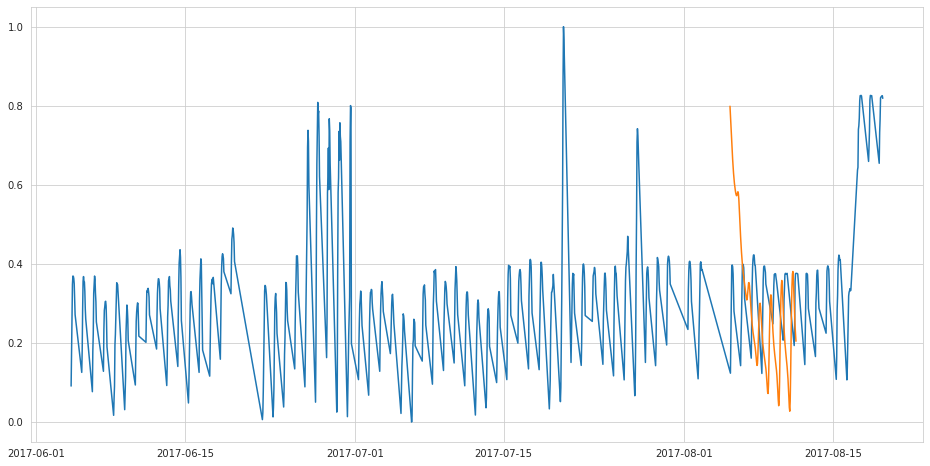

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(df0.index, df0['usage'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

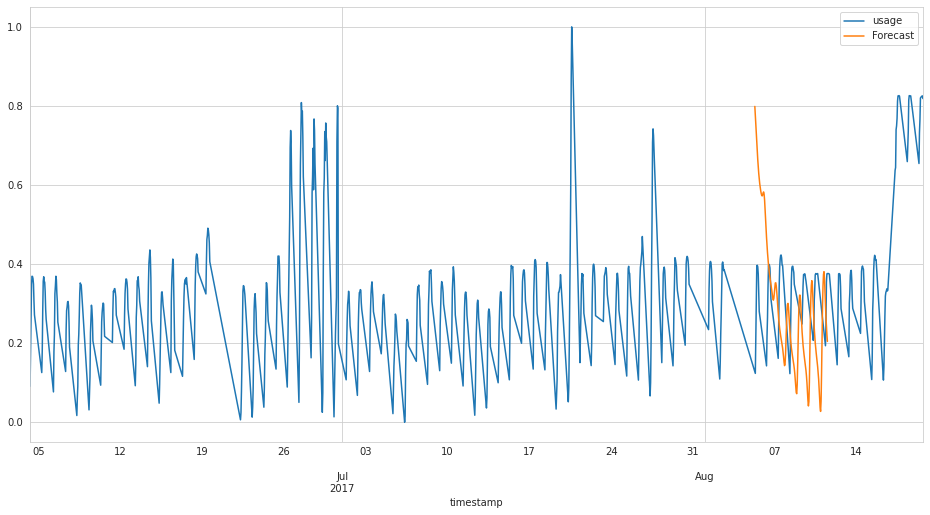

In [ ]:
ax = df0.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(417192.0, 417552.0)

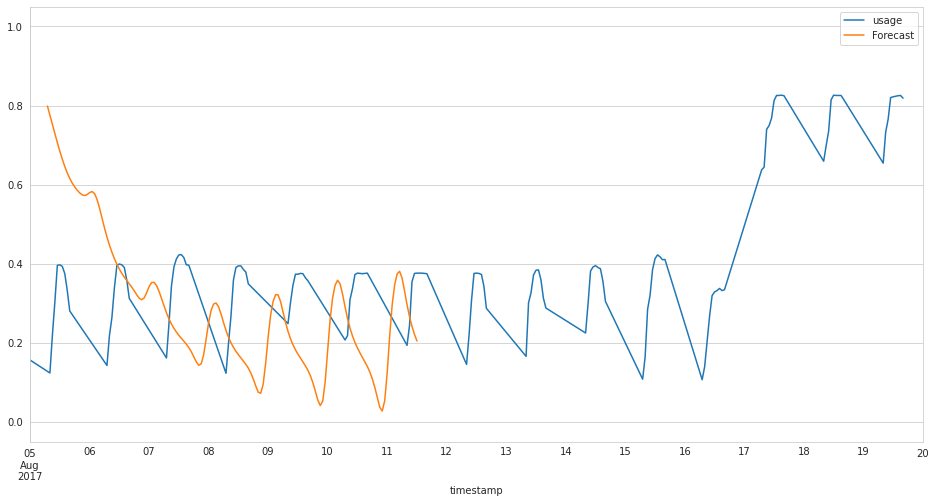

In [ ]:
ax = df0.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2017-08-05 00:00:00', '2017-08-20 00:00:00')

### Last Week

In [ ]:
forecast_index = pd.date_range(start = '2017-08-12 07:00:00', periods = 150, freq = 'H')

In [ ]:
forecast_index

DatetimeIndex(['2017-08-12 07:00:00', '2017-08-12 08:00:00',
               '2017-08-12 09:00:00', '2017-08-12 10:00:00',
               '2017-08-12 11:00:00', '2017-08-12 12:00:00',
               '2017-08-12 13:00:00', '2017-08-12 14:00:00',
               '2017-08-12 15:00:00', '2017-08-12 16:00:00',
               ...
               '2017-08-18 03:00:00', '2017-08-18 04:00:00',
               '2017-08-18 05:00:00', '2017-08-18 06:00:00',
               '2017-08-18 07:00:00', '2017-08-18 08:00:00',
               '2017-08-18 09:00:00', '2017-08-18 10:00:00',
               '2017-08-18 11:00:00', '2017-08-18 12:00:00'],
              dtype='datetime64[ns]', length=150, freq='H')

In [ ]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [ ]:
forecast_df

,Forecast
2017-08-12 07:00:00,0.799
2017-08-12 08:00:00,0.776
2017-08-12 09:00:00,0.752
2017-08-12 10:00:00,0.729
2017-08-12 11:00:00,0.706
...,...
2017-08-18 08:00:00,0.296
2017-08-18 09:00:00,0.266
2017-08-18 10:00:00,0.241
2017-08-18 11:00:00,0.221


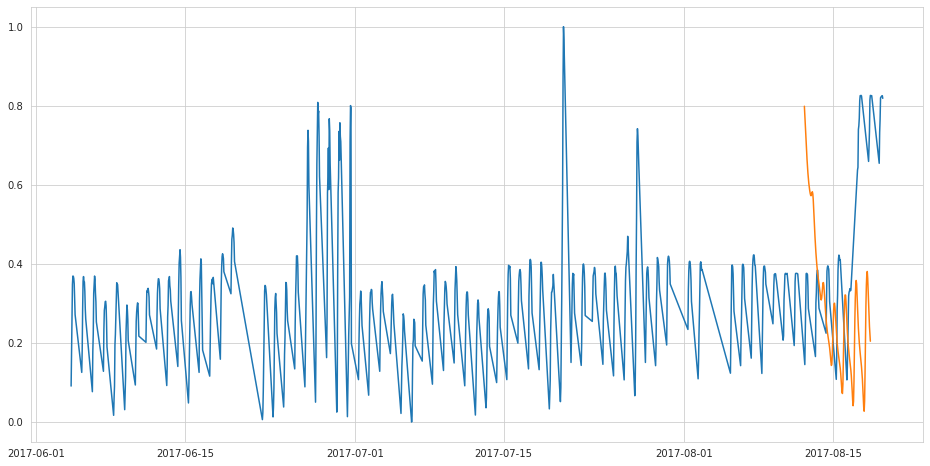

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(df0.index, df0['usage'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

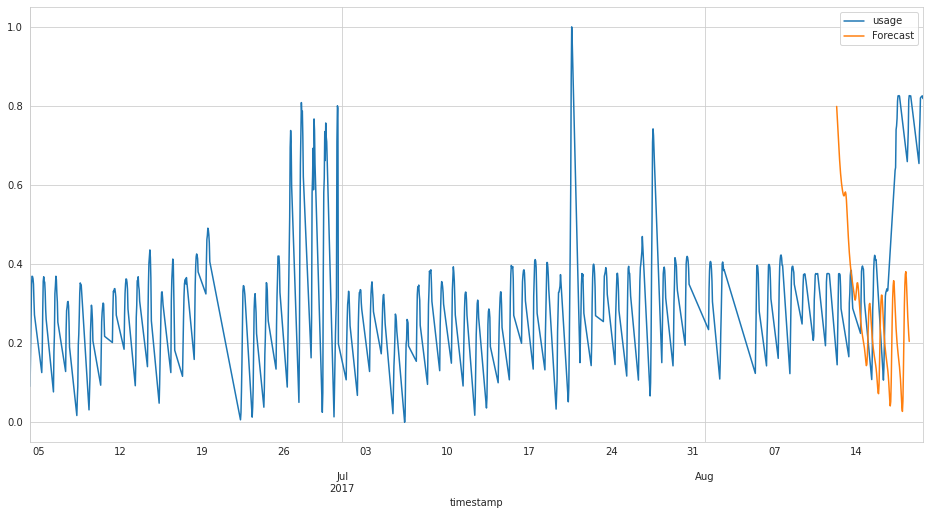

In [ ]:
ax = df0.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(417360.0, 417552.0)

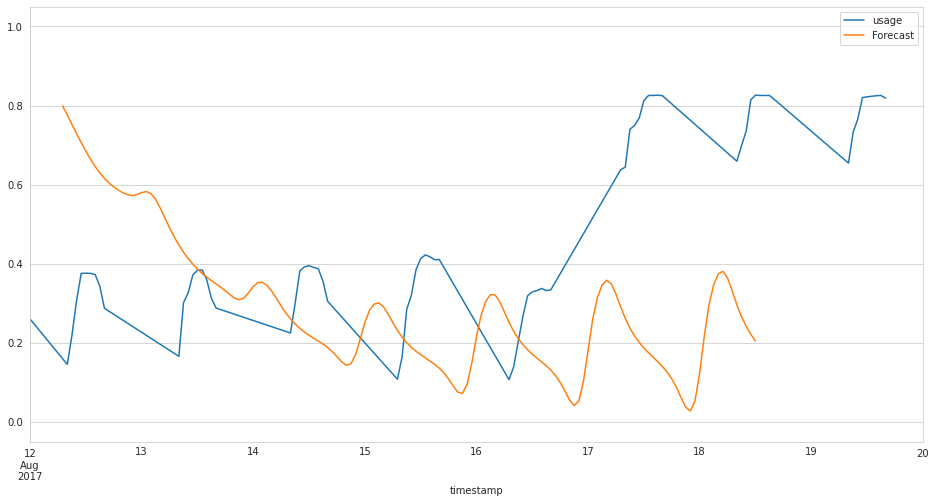

In [ ]:
ax = df0.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2017-08-12 00:00:00', '2017-08-20 00:00:00')